**Table of contents**<a id='toc0_'></a>    
- [Загрузка данных](#toc1_)    
- [Предобработка данных](#toc2_)    
- [Нормализации, масштабирование или кодирование](#toc3_)    
- [Генерация новых признаков](#toc4_)    
- [Отбор признаков](#toc5_)    
- [Логирование в ML FLOW](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

На этом этапе вы будем улучшать  модель с помощью генерации новых признаков. 

# <a id='toc1_'></a>[Загрузка данных](#toc0_)


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.client import MlflowClient
from autofeat import AutoFeatRegressor
from catboost import CatBoostRegressor
import catboost as cb
import numpy as np
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer, PolynomialFeatures, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import random
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import Lars

warnings.simplefilter(action='ignore', category=FutureWarning)

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "fit_exp" # напишите название вашего эксперимента
RUN_NAME = "fit"

FS_ASSETS = 'assets/features'
os.makedirs(FS_ASSETS, exist_ok=True)


pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [ ]:
def get_artifact_runID(name):
    exp_ids=[]
    exps = client.search_experiments()
    got = False
    for e in exps:
        if not got:
            exp_ids.append(e.experiment_id)
            for e_id in exp_ids:
                runs = client.search_runs(e_id)
                for run in runs:
                    if run.info.status !='FAILED' and not got:
                        artifacts = client.list_artifacts(run.info.run_id)
                        #print(artifacts)
                        try:
                            
                            if name in str(artifacts):
                                run_id = run.info.run_id
                                print(run_id)
                                got = True
                        except:
                            pass
    return run_id

In [ ]:
client = MlflowClient()
the_run_id = get_artifact_runID("initial_data.csv")
local_path = client.download_artifacts(the_run_id, "initial_data.csv", 'data')
df = pd.read_csv(local_path)
df.sample(5)

2025-03-11 11:12:43,877 INFO: Found credentials in environment variables.


,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,nearest_metro,distance_to_metro
120194,2,False,11.0,71.000000,4,False,124.000000,13990000,2000,4,2.64,260,14,True,Перово,10.452824
113276,12,True,11.3,43.000000,3,False,74.500000,13400000,2012,4,2.70,384,17,True,Рассказовка,2.753965
78263,6,False,6.0,27.900000,2,False,44.400002,7900000,1975,4,2.50,502,9,True,Марксистская,17.750201
97359,11,False,10.0,19.000000,1,False,35.000000,12800000,1983,6,2.48,105,16,True,Петровский парк,1.496400
31815,10,False,12.0,27.299999,2,False,55.400002,12400000,2018,2,3.00,321,14,True,Озёрная,9.076598


# <a id='toc2_'></a>[Предобработка данных](#toc0_)

Для начала устраним те проблемы в данных, которые выявили на предыдущем этапе анализа.  
Начнём с аномально низких значений.

In [4]:
df = df[df['price']>1000000]

Теперь заменим нули в жилой площади

In [5]:
df['living_area'] = df['total_area']- df['kitchen_area']
#Удалим странные картиры у которых площадь кухни больше общей площади
df = df[df['living_area'] >= -4.3]

In [6]:
print('Список уникальных значений в колонке "studio" = ',df['studio'].unique())
#Удалим столбец "студия" как неинформативный
df = df.drop(['studio'], axis=1)


Список уникальных значений в колонке "studio" =  [False]


# <a id='toc3_'></a>[Нормализации, масштабирование или кодирование](#toc0_)

In [ ]:


RANDOM_STATE = 42
random.seed(RANDOM_STATE)

degree = 3
n_bins = 10
encode = 'ordinal'
strategy = 'uniform'
subsample = None

# Создаем column transformer
cats = ['is_apartment', 'rooms', 'nearest_metro', 'has_elevator']
bins = ['build_year', 'ceiling_height', 'flats_count', 'floors_total','floor']
nums = ['kitchen_area', 'living_area', 'total_area','distance_to_metro']

# Исправляем numeric_transformer - используем только один трансформер для каждой колонки
numeric_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=degree)),
    ('scaler', RobustScaler())
])

bin_transformer = Pipeline(steps=[
    ('KBinsDiscretizer', KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)),
    ('categorizer', TargetEncoder(target_type = 'continuous', smooth='auto')),
])

# Исправляем cats_transformer - правильный формат для ColumnTransformer
cats_transformer = ColumnTransformer([
    ('encoder', TargetEncoder(target_type = 'continuous', smooth='auto'), cats),
    ('bins_to_cats', bin_transformer, bins)
])

# Создаем pipeline
pipeline = ColumnTransformer([
    ('numeric', PolynomialFeatures(degree=degree),nums),
    ('cats_transformer', cats_transformer, bins+cats)
])


X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1), 
    df['price'], 
    test_size=0.25,  # 25% для обучения, 75% для теста
    random_state=RANDOM_STATE
)

# Применяем pipeline
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(
    X_train_transformed, 
    columns=pipeline.get_feature_names_out(),
    index = y_train.index
)

X_test_transformed = pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(
    X_test_transformed, 
    columns=pipeline.get_feature_names_out(),
    index = y_test.index)

# <a id='toc4_'></a>[Генерация новых признаков](#toc0_)

In [ ]:
def remove_zero_variance_features(df1):
    # Let's say you want to find features with near zero variance
    # First, define a threshold for variance
    threshold = 0.01  # This value can be adjusted based on your needs

    # Initialize VarianceThreshold from Scikit-Learn with the defined threshold
    selector = VarianceThreshold(threshold=threshold)

    # Fit this selector to your data
    selector.fit(df1)

    # Boolean array: True if feature's variance is above the threshold
    features = selector.get_support(indices=True)

    # Get a DataFrame with removed low variance features
    df_high_variance = df1.iloc[:, features]


    # Additionally, if you want to know which features were removed:
    removed_features = [column for column in df1.columns
                    if column not in df_high_variance.columns]

    print('Removed features with near zero variance:')
    print(removed_features)
    return removed_features

In [9]:
removed_features = remove_zero_variance_features(X_train_transformed)
X_train_transformed = X_train_transformed.drop(removed_features, axis=1)
X_test_transformed = X_test_transformed.drop(removed_features, axis=1)

Removed features with near zero variance:
['numeric__1']


In [10]:
# Подготовка списка колонок
lst = list(X_train_transformed.columns)
numeric_lst = [x for x in lst if x.startswith('numeric')]
other_lst = [x for x in lst if not x.startswith('numeric')]
transformations = ['log', 'sqrt', 'cos']

# Инициализация модели
afr = AutoFeatRegressor(
#    categorical_cols=[cats[2]],
    feateng_cols=nums,
    transformations=transformations,
    max_gb=16,
    feateng_steps=2,
    n_jobs=1,
    verbose=1
)
X_train_transformed_afr = afr.fit_transform(X_train[nums], y_train)
X_test_transformed_afr = afr.transform(X_test[nums])

2025-03-11 08:54:48,769 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 78 features.
2025-03-11 08:54:48,770 INFO: [AutoFeat] With 95163 data points this new feature matrix would use about 0.03 gb of space.
2025-03-11 08:54:48,773 INFO: [feateng] Step 1: transformation of original features


2025-03-11 08:54:50,081 INFO: [feateng] Generated 10 transformed features from 4 original features - done.
2025-03-11 08:54:50,086 INFO: [feateng] Step 2: first combination of features


2025-03-11 08:54:50,748 INFO: [feateng] Generated 91 feature combinations from 91 original feature tuples - done.
2025-03-11 08:54:50,797 INFO: [feateng] Generated altogether 103 new features in 2 steps
2025-03-11 08:54:50,799 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2025-03-11 08:54:50,944 INFO: [feateng] Generated a total of 61 additional features
2025-03-11 08:54:51,125 INFO: [featsel] Feature selection run 1/5


[featsel] Scaling data...done.


2025-03-11 08:55:03,337 INFO: [featsel] Feature selection run 2/5
2025-03-11 08:55:15,889 INFO: [featsel] Feature selection run 3/5
2025-03-11 08:55:29,575 INFO: [featsel] Feature selection run 4/5
2025-03-11 08:55:41,213 INFO: [featsel] Feature selection run 5/5
2025-03-11 08:55:51,081 INFO: [featsel] 52 features after 5 feature selection runs
2025-03-11 08:55:53,201 INFO: [featsel] 19 features after correlation filtering
2025-03-11 08:55:54,156 INFO: [featsel] 18 features after noise filtering
2025-03-11 08:55:54,157 INFO: [AutoFeat] Computing 15 new features.


2025-03-11 08:55:56,822 INFO: [AutoFeat]    15/   15 new features ...done.
2025-03-11 08:55:56,830 INFO: [AutoFeat] Final dataframe with 19 feature columns (15 new).
2025-03-11 08:55:56,831 INFO: [AutoFeat] Training final regression model.
2025-03-11 08:55:57,134 INFO: [AutoFeat] Trained model: largest coefficients:
2025-03-11 08:55:57,135 INFO: 1318130.7094028573
2025-03-11 08:55:57,136 INFO: -824827.991858 * cos(distance_to_metro)
2025-03-11 08:55:57,137 INFO: 470612.232229 * kitchen_area
2025-03-11 08:55:57,137 INFO: 227358.669725 * living_area
2025-03-11 08:55:57,138 INFO: 204320.634506 * cos(distance_to_metro)*cos(kitchen_area)
2025-03-11 08:55:57,139 INFO: 185336.935353 * cos(kitchen_area)*cos(living_area)
2025-03-11 08:55:57,139 INFO: -145854.218939 * cos(total_area)
2025-03-11 08:55:57,140 INFO: -126914.909530 * sqrt(kitchen_area)*log(distance_to_metro)
2025-03-11 08:55:57,141 INFO: -102275.020556 * cos(living_area)
2025-03-11 08:55:57,141 INFO: -86534.084767 * cos(distance_to_

In [11]:
X_train_transformed_afr = X_train_transformed_afr.drop(nums, axis=1)
X_test_transformed_afr = X_test_transformed_afr.drop(nums, axis=1)


In [12]:
print(X_test_transformed.shape)
print(X_test_transformed_afr.shape)

(31722, 43)
(31722, 15)


In [13]:
X_train_transformed.index = y_train.index
X_train_transformed_afr.index = y_train.index
X_test_transformed.index = y_test.index
X_test_transformed_afr.index = y_test.index

In [14]:
X_mega_train = pd.concat([X_train_transformed, X_train_transformed_afr], axis=1, ignore_index=True, verify_integrity=True)
X_mega_test = pd.concat([X_test_transformed, X_test_transformed_afr], axis=1, ignore_index=True, verify_integrity=True)


In [15]:
print(X_mega_train.shape)
print(X_mega_test.shape)

(95163, 58)
(31722, 58)


In [16]:
X_mega_train.columns = list(X_train_transformed.columns)+list(X_train_transformed_afr.columns)
X_mega_test.columns = list(X_test_transformed.columns)+list(X_test_transformed_afr.columns)

Проведём для верности проверку на взаимную корреляцию получившихся признаков

In [17]:
# Create correlation matrix
corr_matrix = X_mega_train.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features
#df.drop(to_drop, axis=1, inplace=True)
print(to_drop)

['numeric__total_area', 'numeric__kitchen_area total_area', 'numeric__living_area^2', 'numeric__living_area total_area', 'numeric__total_area^2', 'numeric__total_area distance_to_metro', 'numeric__kitchen_area^2 total_area', 'numeric__kitchen_area living_area total_area', 'numeric__kitchen_area total_area^2', 'numeric__kitchen_area total_area distance_to_metro', 'numeric__living_area^2 total_area', 'numeric__living_area total_area^2', 'numeric__living_area total_area distance_to_metro', 'numeric__total_area^3', 'numeric__total_area^2 distance_to_metro', 'numeric__total_area distance_to_metro^2', 'numeric__distance_to_metro^3', 'kitchen_area*total_area', 'distance_to_metro*living_area']


In [18]:
X_mega_train = X_mega_train.drop(to_drop, axis =1)
X_mega_test = X_mega_test.drop(to_drop, axis =1)

Обучим теперь модель на всём этом многообразии и посмотрим, что получилось.

In [ ]:
cat_features = X_mega_train.select_dtypes(include='object')

fit_params = {
        'learning_rate': 0.1,
        'min_child_samples': 5,
        'depth': 6,
        'loss_function': 'RMSE',
        'random_state': RANDOM_STATE,
    }
model = CatBoostRegressor(**fit_params, cat_features=cat_features.columns.tolist())

model.fit(X_mega_train, y_train) 
print('Model  fitted sucessfully')

0:	learn: 4718893.6579291	total: 110ms	remaining: 1m 50s
1:	learn: 4470825.2086361	total: 163ms	remaining: 1m 21s
2:	learn: 4258638.5507557	total: 192ms	remaining: 1m 3s
3:	learn: 4073382.7872181	total: 220ms	remaining: 54.7s
4:	learn: 3916796.5131089	total: 260ms	remaining: 51.7s
5:	learn: 3777801.2608033	total: 318ms	remaining: 52.7s
6:	learn: 3657422.8865790	total: 371ms	remaining: 52.6s
7:	learn: 3553683.5634572	total: 398ms	remaining: 49.3s
8:	learn: 3462202.7698450	total: 423ms	remaining: 46.6s
9:	learn: 3384180.6818617	total: 452ms	remaining: 44.8s
10:	learn: 3315866.8406388	total: 495ms	remaining: 44.5s
11:	learn: 3255650.0477485	total: 550ms	remaining: 45.3s
12:	learn: 3208474.6629936	total: 636ms	remaining: 48.3s
13:	learn: 3161650.5845078	total: 683ms	remaining: 48.1s
14:	learn: 3123365.1880300	total: 713ms	remaining: 46.8s
15:	learn: 3090950.5350554	total: 759ms	remaining: 46.7s
16:	learn: 3059232.6738278	total: 810ms	remaining: 46.9s
17:	learn: 3032131.7240640	total: 866ms

Проведём валидацию модели на тестовых данных

In [ ]:

pred = model.predict(X_mega_test)
metrics ={
            'neg_mean_absolute_error': - mean_absolute_error(pred, y_test),
            'neg_root_mean_squared_error': - mean_squared_error(pred, y_test),
            'r2': r2_score(pred, y_test),
            'neg_mean_absolute_percentage_error': - mean_absolute_percentage_error(pred, y_test)
        }
metrics

{'neg_mean_absolute_error': -1986076.8515262315,
 'neg_root_mean_squared_error': -6735656583980.154,
 'r2': 0.6227341594562563,
 'neg_mean_absolute_percentage_error': -0.16319181375866382}

                                           feature  importance
19        cats_transformer__encoder__nearest_metro   22.307790
11             numeric__kitchen_area living_area^2   10.776869
2                       numeric__distance_to_metro   10.594695
14                          numeric__living_area^3    9.950032
1                             numeric__living_area    7.967457
7                     numeric__distance_to_metro^2    7.374796
21      cats_transformer__bins_to_cats__build_year    4.890971
4                numeric__kitchen_area living_area    4.215936
24    cats_transformer__bins_to_cats__floors_total    2.100329
18                cats_transformer__encoder__rooms    1.923585
9              numeric__kitchen_area^2 living_area    1.755200
28                          cos(distance_to_metro)    1.461855
36        distance_to_metro*cos(distance_to_metro)    1.372863
20         cats_transformer__encoder__has_elevator    1.107064
16        numeric__living_area distance_to_metro^2    1

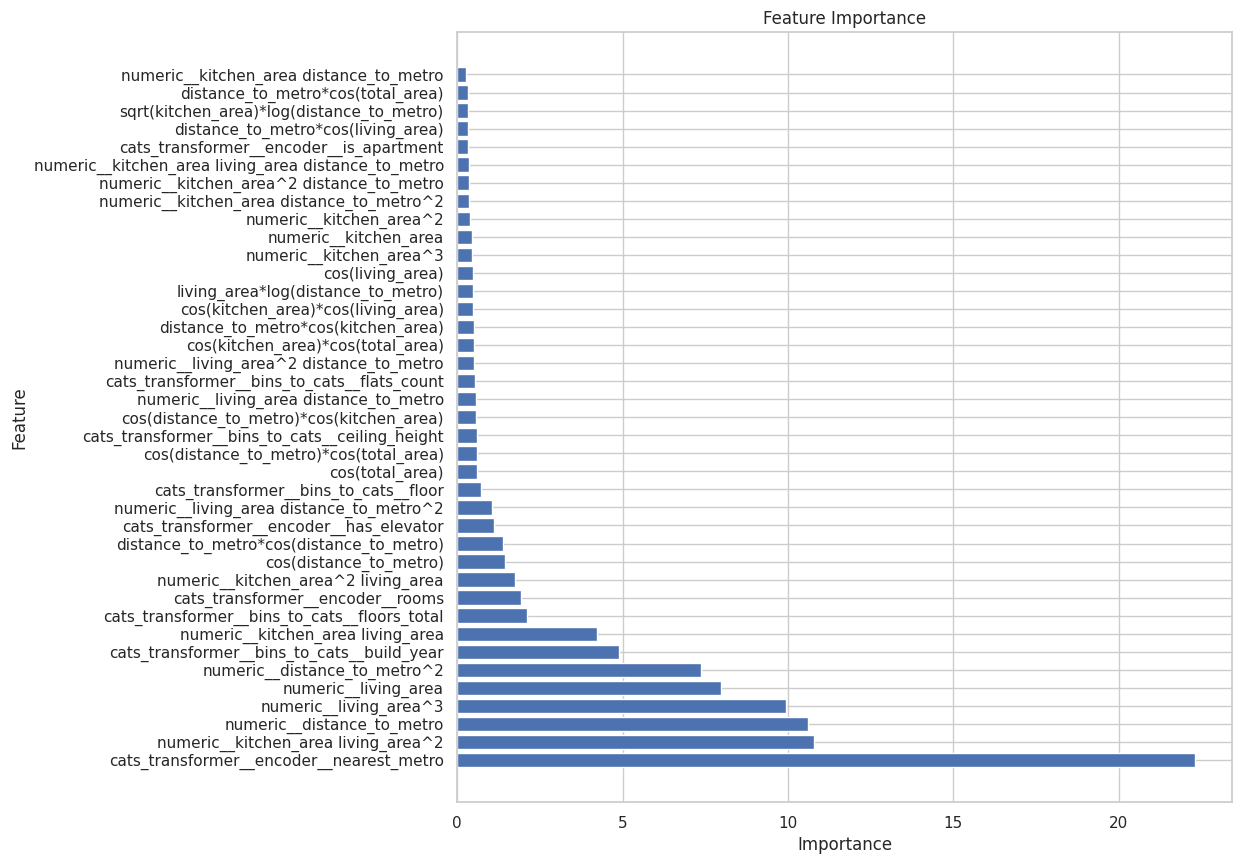

In [ ]:

# создаем объект Pool
pool = cb.Pool(X_mega_train, y_train)

# получаем важность признаков
feature_importance = model.get_feature_importance(pool)

# создаем DataFrame с важностью признаков
dfi = pd.DataFrame({'feature': X_mega_train.columns, 'importance': feature_importance})

# сортируем DataFrame по важности признаков
dfi = dfi.sort_values('importance', ascending=False)

# выводим топ-20 самых важных признаков
print(dfi.head(20))

# создаем график
plt.figure(figsize=(10, 10))
plt.barh(dfi['feature'], dfi['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig(f"{FS_ASSETS}//feat_imp.png") 
plt.show()

# <a id='toc5_'></a>[Отбор признаков](#toc0_)

In [22]:
keep20 = dfi['feature'].head(40).to_list()

In [ ]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
estimator = Lars(n_nonzero_coefs=1)

sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)
sbs = SFS(estimator, k_features=10, forward=False, floating=False, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

sfs = sfs.fit(X_mega_train[keep20], y_train)
sbs = sbs.fit(X_mega_train[keep20], y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python


Sequential Forward Selection (k=10)
CV Score:
-2796389.8374959896

Sequential Backward Selection
CV Score:
-2796389.8374959896


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


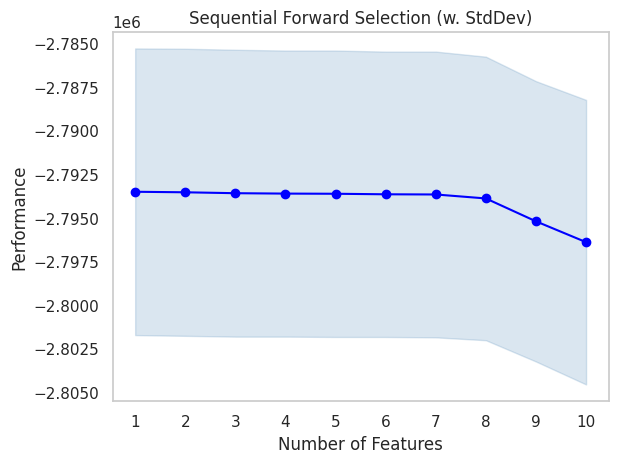

In [24]:

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}//sfs.png") 
plt.show()

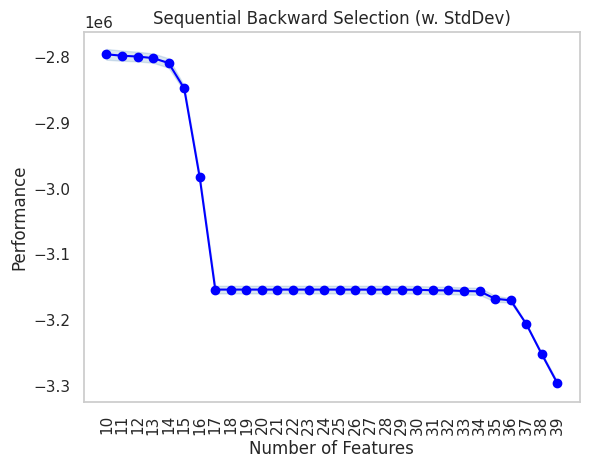

In [27]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sbs.png") 
plt.gca().set_xticklabels(range(10,40,1), rotation = 90)
plt.show()

Вывод: Автоматизированный отбор признаков не дал результата, но это скорее связано с тем, что в его основе быстродействующая, но не походящая к случаю модель LARS, я попробовал проводить отбор на catboost, но после 40 минут ожидания понял, что это безнадёжно. Но мы попробуем переобучить catboost, используя отобранные на данном этапе признаки.

In [45]:
top_sfs =list(top_sfs)
top_sbs =list(top_sbs)
model_sfs=CatBoostRegressor(**fit_params)
model_sbs=CatBoostRegressor(**fit_params)
model_sfs.fit(X_mega_train[top_sfs], y_train) 
model_sbs.fit(X_mega_train[top_sbs], y_train) 
pred1 = model_sfs.predict(X_mega_test[top_sfs])
pred2 = model_sbs.predict(X_mega_test[top_sbs])
metrics1 ={
            'neg_mean_absolute_error': - mean_absolute_error(pred1, y_test),
            'neg_root_mean_squared_error': - mean_squared_error(pred1, y_test),
            'r2': r2_score(pred1, y_test),
            'neg_mean_absolute_percentage_error': - mean_absolute_percentage_error(pred1, y_test)
        }
metrics2 ={
            'neg_mean_absolute_error': - mean_absolute_error(pred2, y_test),
            'neg_root_mean_squared_error': - mean_squared_error(pred2, y_test),
            'r2': r2_score(pred2, y_test),
            'neg_mean_absolute_percentage_error': - mean_absolute_percentage_error(pred2, y_test)
        }

eva = pd.DataFrame()
eva['base'] = metrics.values()
eva['sfs'] = metrics1.values()
eva['sbs'] = metrics2.values()


0:	learn: 4780010.4346567	total: 24.7ms	remaining: 24.7s
1:	learn: 4596562.5648205	total: 38.6ms	remaining: 19.3s
2:	learn: 4436459.7418491	total: 52.6ms	remaining: 17.5s
3:	learn: 4300295.6254757	total: 66.3ms	remaining: 16.5s
4:	learn: 4179715.9808369	total: 79.9ms	remaining: 15.9s
5:	learn: 4077069.2502006	total: 94ms	remaining: 15.6s
6:	learn: 3993928.8169766	total: 107ms	remaining: 15.2s
7:	learn: 3920844.7824827	total: 129ms	remaining: 16s
8:	learn: 3858692.4325062	total: 159ms	remaining: 17.5s
9:	learn: 3809781.0329060	total: 189ms	remaining: 18.7s
10:	learn: 3765629.3249199	total: 215ms	remaining: 19.4s
11:	learn: 3728574.9289843	total: 231ms	remaining: 19s
12:	learn: 3697874.7000599	total: 245ms	remaining: 18.6s
13:	learn: 3669466.7031894	total: 259ms	remaining: 18.2s
14:	learn: 3646437.3251390	total: 272ms	remaining: 17.8s
15:	learn: 3625978.1131749	total: 287ms	remaining: 17.6s
16:	learn: 3607768.7966963	total: 301ms	remaining: 17.4s
17:	learn: 3590806.1058350	total: 313ms	r

In [48]:
eva.index = metrics1.keys()
eva.style.format(decimal=",", thousands=" ", precision=2)


,base,sfs,sbs
neg_mean_absolute_error,"-1 986 076,85","-2 440 909,07","-2 440 909,07"
neg_root_mean_squared_error,"-6 735 656 583 980,15","-10 601 966 827 285,67","-10 601 966 827 285,67"
r2,"0,62","0,24","0,24"
neg_mean_absolute_percentage_error,"-0,16","-0,20","-0,20"


Мы видим, что так признаки отбирать точно не стоит, так как все метрики упали и весьма значительно, если посмотерть, например на относительные показатели. 
Так что просто воспользуемся ТОП-10 метрик по версии catboost.

In [52]:
keep20 = dfi['feature'].head(10).to_list()
model_light=CatBoostRegressor(**fit_params)
model_light.fit(X_mega_train[keep20], y_train) 
pred3 = model_light.predict(X_mega_test[keep20])
metrics3 ={
            'neg_mean_absolute_error': - mean_absolute_error(pred3, y_test),
            'neg_root_mean_squared_error': - mean_squared_error(pred3, y_test),
            'r2': r2_score(pred2, y_test),
            'neg_mean_absolute_percentage_error': - mean_absolute_percentage_error(pred3, y_test)
        }
eva['light'] = metrics3.values()
eva.style.format(decimal=",", thousands=" ", precision=2)

0:	learn: 4719504.2527495	total: 18.2ms	remaining: 18.2s
1:	learn: 4473083.2256816	total: 33.5ms	remaining: 16.7s
2:	learn: 4261416.9552756	total: 49.5ms	remaining: 16.5s
3:	learn: 4077714.2599546	total: 65.7ms	remaining: 16.4s
4:	learn: 3916525.0394947	total: 81.5ms	remaining: 16.2s
5:	learn: 3778578.5537568	total: 96.4ms	remaining: 16s
6:	learn: 3658289.0840883	total: 113ms	remaining: 16s
7:	learn: 3550679.9216694	total: 128ms	remaining: 15.9s
8:	learn: 3462667.0983207	total: 144ms	remaining: 15.8s
9:	learn: 3381566.8246070	total: 159ms	remaining: 15.7s
10:	learn: 3312823.8010831	total: 175ms	remaining: 15.8s
11:	learn: 3257790.8054332	total: 190ms	remaining: 15.6s
12:	learn: 3206897.3393157	total: 202ms	remaining: 15.3s
13:	learn: 3162182.0984731	total: 215ms	remaining: 15.1s
14:	learn: 3124091.5145699	total: 228ms	remaining: 15s
15:	learn: 3089529.5200801	total: 241ms	remaining: 14.8s
16:	learn: 3059286.0936548	total: 253ms	remaining: 14.6s
17:	learn: 3034233.7777881	total: 267ms	r

,base,sfs,sbs,light
neg_mean_absolute_error,"-1 986 076,85","-2 440 909,07","-2 440 909,07","-2 003 355,94"
neg_root_mean_squared_error,"-6 735 656 583 980,15","-10 601 966 827 285,67","-10 601 966 827 285,67","-6 842 215 518 060,09"
r2,"0,62","0,24","0,24","0,24"
neg_mean_absolute_percentage_error,"-0,16","-0,20","-0,20","-0,16"


Вот так, модель стало значительно шустрее, но при этом точность на уровне базового сценария, где признаков было аж 58 штук. Сохраним обучающий и тестовый набор данных для дальнейших экспериментов.

In [60]:
filtered_train = X_mega_train[keep20]
filtered_test = X_mega_test[keep20]
filtered_train['y']=y_train
filtered_test['y']=y_test
filtered_train.to_csv(f"{FS_ASSETS}/f_train.csv", sep=',', index=False, encoding='utf-8')
filtered_test.to_csv(f"{FS_ASSETS}/f_test.csv", sep=',', index=False, encoding='utf-8')

/tmp/ipykernel_3114/2134591239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['y']=y_train
/tmp/ipykernel_3114/2134591239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test['y']=y_test


# <a id='toc6_'></a>[Логирование в ML FLOW](#toc0_)

In [61]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 
mlflow.set_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
with mlflow.start_run(run_name='preprocessing', experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS) 
    #Логируем трубопровод для обработки данных
    metadata = {"model_type": "preprocessing", 'structure': 'sklearn'}
    train_data = X_test.head(5)
    pred = pipeline.transform(train_data)
    signature = mlflow.models.infer_signature(train_data, pred)
    input_example = train_data
    pip_requirements = '/home/mle-user/mle_projects/yn/requirements.txt'
    model_info = mlflow.sklearn.log_model( 
		    sk_model=pipeline,
            artifact_path="models",
            registered_model_name='preprocessor',
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements,
            metadata = metadata,
            await_registration_for=60
		)
with mlflow.start_run(run_name='feature_generation', experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS) 
    #Логируем модель на полном многообразии признаков
    metadata = {"model_type": "maximum_features", 'structure': 'catboost'}
    train_data = X_mega_test.head(5)
    pred = model.predict(train_data)
    signature = mlflow.models.infer_signature(train_data, pred)
    input_example = train_data
    pip_requirements = '/home/mle-user/mle_projects/yn/requirements.txt'
    model_info = mlflow.catboost.log_model( 
		cb_model=model,
            artifact_path="models",
            registered_model_name='maximum_features',
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements,
            metadata = metadata,
            await_registration_for=60
		)
    mlflow.log_params(fit_params)
    mlflow.log_metrics(metrics)
    #Логируем c отобраными признаками
with mlflow.start_run(run_name='feature_selection', experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS) 
    metadata = {"model_type": "light", 'structure': 'catboost'}
    train_data = X_mega_test[keep20].head(5)
    pred = model_light.predict(train_data)
    signature = mlflow.models.infer_signature(train_data, pred)
    input_example = train_data
    pip_requirements = '/home/mle-user/mle_projects/yn/requirements.txt'
    model_info = mlflow.catboost.log_model( 
		cb_model=model_light,
            artifact_path="models",
            registered_model_name='light',
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements,
            metadata = metadata,
            await_registration_for=60
		)
    mlflow.log_metrics(metrics3)

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
2025/03/11 09:57:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/mle-user/mle_projects/.venv/lib/python3